## Import and prep

In [57]:
!pip install open_clip_torch torch torchvision

DEPRECATION: celery 4.4.0 has a non-standard dependency specifier pytz>dev. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Obtaining dependency information for torchao==0.12.0 from https://files.pythonhosted.org/packages/6c/5f/6bf9b5bed6d31e286516d23e1db7320d2ccfbf1b2234749833ad1e3d25a5/torchao-0.12.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.2/962.2 kB 9.0 MB/s eta 0:00:00a 0:00:01
DEPRECATION: celery 4.4.0 has a non-standard dependency specifier pytz>dev. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/is

In [2]:
import torch
import open_clip
import requests
from PIL import Image
import os
import zipfile
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from huggingface_hub import hf_hub_download
import json
import copy

/Users/mahan_yt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Dowload testing dataset


In [ ]:
# download dataset
DATASET_URL = "https://www.kaggle.com/api/v1/datasets/download/nguyenletruongthien/animals-and-plants-dataset"

# Download and unzip the dataset

if not os.path.exists("animal_plant_samples"):
    try:
        with requests.get(DATASET_URL, stream=True) as r:
            r.raise_for_status()
            with open("animals-and-plants-dataset.zip", "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        with zipfile.ZipFile("animals-and-plants-dataset.zip", 'r') as zip_ref:
            zip_ref.extractall("animal_plant_samples")
        os.remove("animals-and-plants-dataset.zip")
    except Exception as e:
        print(f"An error occurred while downloading or extracting the dataset: {e}")
            

## Loading the main Model

In [3]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip-2')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip-2')

In [22]:
logit_scale_value = model.logit_scale.exp().item()
print(f"Logit scale value: {logit_scale_value}")

# Save it for later use
import pickle

with open("logit_scale.pkl", "wb") as f:
    pickle.dump(logit_scale_value, f)


Logit scale value: 100.00000762939453


## Model prediction function

Based on the demo at https://huggingface.co/spaces/imageomics/bioclip-2-demo

We are going to use the open_domain_classification

In [4]:
preprocess_img = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)


In [5]:
txt_emb = torch.from_numpy(
    np.load(
        hf_hub_download(
            repo_id="imageomics/TreeOfLife-200M",
            filename="embeddings/txt_emb_species.npy",
            repo_type="dataset",
        )
    )
)
with open(hf_hub_download(
        repo_id="imageomics/TreeOfLife-200M",
        filename="embeddings/txt_emb_species.json",
        repo_type="dataset",
    )) as fd:
        txt_names = json.load(fd)

In [6]:
ranks = ("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")
device = torch.device("cpu")


In [7]:
def format_name(taxon, common):
    if not common:
        return " ".join(taxon)
    else:
        return f"{common}"


In [8]:
@torch.no_grad()
def open_domain_classification(img):
    """
    Predicts from the entire tree of life.
    If targeting a higher rank than species, then this function predicts among all
    species, then sums up species-level probabilities for the given rank.
    """
    k = 1

    img = preprocess_img(img).to(device)
    img_features = model.encode_image(img.unsqueeze(0))
    img_features = F.normalize(img_features, dim=-1)

    logits = (model.logit_scale.exp() * img_features @ txt_emb).squeeze()
    probs = F.softmax(logits, dim=0)

    topk = probs.topk(k)
    prediction_dict = {
        format_name(*txt_names[i]): prob
        for i, prob in zip(topk.indices, topk.values)
    }
    print(f"INFO: prediction with prob.: {prediction_dict}")
    return prediction_dict


## Test Main Model accuracy on dataset

In [9]:
prediction_dic = open_domain_classification(
    Image.open(
        "animal_plant_samples/Animals and Plants Dataset/train/Aves/Aves_image_1000.jpg"
    )
)
prediction_dic

prediction_name = str(*prediction_dic.keys())
print(f"prediction name: {prediction_name}")


INFO: prediction with prob.: {'Marbled Godwit': tensor(0.5502)}
prediction name: Marbled Godwit


## Model Quantization

### Install ONNX dependencies

In [69]:
!pip install onnx onnxruntime onnxruntime-tools

  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/36/07/0019c72924909e4f64b9199770630ab7b8d7914b912b03230e68f5eda7ae/onnx-1.19.1-cp311-cp311-macosx_12_0_universal2.whl.metadata
  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/44/be/467b00f09061572f022ffd17e49e49e5a7a789056bad95b54dfd3bee73ff/onnxruntime-1.23.2-cp311-cp311-macosx_13_0_arm64.whl.metadata
  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/44/be/467b00f09061572f022ffd17e49e49e5a7a789056bad95b54dfd3bee73ff/onnxruntime-1.23.2-cp311-cp311-macosx_13_0_arm64.whl.metadata
  Obtaining dependency information for onnxruntime-tools from https://files.pythonhosted.org/packages/6f/b0/db0e73356df0aaa8737e6f13c0dac499b5d904d3fa267c8ebf24515e8001/onnxruntime_tools-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for onnxruntime-tools from https://files.pythonhosted.org/packages/6f/b0/db0e733

In [10]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

onnx_path = "bioclip2_model.onnx"

### Export model to ONNX format

In [70]:

# Export the vision model to ONNX
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
torch.onnx.export(
    model.visual,  # Export the vision encoder
    dummy_input,
    onnx_path,
    input_names=['image'],
    output_names=['image_features'],
    dynamic_axes={
        'image': {0: 'batch_size'},
        'image_features': {0: 'batch_size'}
    },
    opset_version=14,
    do_constant_folding=True
)

print(f"Model exported to {onnx_path}")


Model exported to bioclip2_model.onnx
Original ONNX model size: 1160.26 MB


### Quantize to INT8 (Dynamic Quantization)

In [11]:
quantized_int8_path = "bioclip2_model_int8.onnx"

In [12]:
# Quantize to INT8

quantize_dynamic(
    onnx_path,
    quantized_int8_path,
    weight_type=QuantType.QUInt8  # INT8 quantization
)


### Load and test the quantized ONNX models

In [12]:
import os
original_size = os.path.getsize(onnx_path) // (1024 * 1024)
int8_size = os.path.getsize(quantized_int8_path) // (1024 * 1024)

In [13]:
import onnxruntime as ort

# Create ONNX inference sessions
print("Loading ONNX models...")

# Load INT8 model
session_int8 = ort.InferenceSession(quantized_int8_path, providers=['CPUExecutionProvider'])
print(f"✓ INT8 model loaded")

print("\nModel comparison:")
print(f"Original PyTorch model: ~{original_size:.2f} MB")
print(f"INT8 ONNX model: {int8_size:.2f} MB ({int8_size/original_size*100:.1f}% of original)")

Loading ONNX models...
✓ INT8 model loaded

Model comparison:
Original PyTorch model: ~1160.00 MB
INT8 ONNX model: 292.00 MB (25.2% of original)


### Create inference function for ONNX models

In [14]:
def open_domain_classification_onnx(img, session, model_name="ONNX"):
    """
    Predicts from the entire tree of life using ONNX quantized model.
    """
    k = 1

    # Preprocess image
    img_tensor = preprocess_img(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    
    # Run ONNX inference
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    img_features_np = session.run([output_name], {input_name: img_np})[0]
    
    # Convert back to torch for compatibility with existing code
    img_features = torch.from_numpy(img_features_np)
    img_features = F.normalize(img_features, dim=-1)

    # Use the same text embeddings and logit scale from the original model
    logits = (model.logit_scale.exp() * img_features @ txt_emb).squeeze()
    probs = F.softmax(logits, dim=0)

    topk = probs.topk(k)
    prediction_dict = {
        format_name(*txt_names[i]): prob
        for i, prob in zip(topk.indices, topk.values)
    }
    print(f"INFO [{model_name}]: prediction with prob.: {prediction_dict}")
    return prediction_dict

### Test quantized models on sample image

In [15]:
test_image = Image.open(
    "animal_plant_samples/Animals and Plants Dataset/train/Mammalia/Mammalia_image_0009.jpg"
)

print("Testing different model versions:\n")

# Test original PyTorch model
print("1. Original PyTorch Model:")
prediction_original = open_domain_classification(test_image)

# Test INT8 ONNX model
print("\n2. INT8 Quantized ONNX Model:")
prediction_int8 = open_domain_classification_onnx(test_image, session_int8, "INT8 ONNX")

Testing different model versions:

1. Original PyTorch Model:
INFO: prediction with prob.: {'Coyote': tensor(0.9172)}

2. INT8 Quantized ONNX Model:
INFO [INT8 ONNX]: prediction with prob.: {'Coyote': tensor(0.9304, grad_fn=<UnbindBackward0>)}


## Accuracy comparison of the two models


In [16]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter

def process_image(img_path, category):
    """Process a single image and return results"""
    try:
        img = Image.open(img_path)
        
        pred_original = open_domain_classification(img)
        pred_original_name = str(*pred_original.keys())
        pred_int8 = open_domain_classification_onnx(img, session_int8, "INT8 ONNX")
        pred_int8_name = str(*pred_int8.keys())

        correct = 1 if pred_original_name == pred_int8_name else 0
        
        return correct , {img_path: (pred_original_name, pred_int8_name)}, category
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return 0, {}

# Collect all image paths first
image_paths = []
for root, dirs, files in os.walk(
    "animal_plant_samples/Animals and Plants Dataset/train"
):
    for file in files:
        if file.endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(root, file)
            category = os.path.basename(os.path.dirname(img_path))
            image_paths.append((img_path, category))

category_counts = Counter(category for _, category in image_paths)

total_images = len(image_paths)
print(f"Found {total_images} images to process\n")
print(f"Found {len(set(category for _, category in image_paths))} categories to process\n")

total_correct = 0
category_correct = {}

# Process images in parallel with progress reporting
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(process_image, img_path, category): (img_path, category)
               for img_path, category in image_paths}
    
    for i, future in enumerate(as_completed(futures), 1):
        try:
            result = future.result()
            orig_correct = result[0]
            total_correct += orig_correct
            category = result[2]  # Get category from result
            category_correct[category] = category_correct.get(category, 0) + orig_correct
            print(
                f"Category '{category}': {category_correct[category]} correct images with total of {category_counts[category]} images\n"
            )
        except Exception as e:
            print(f"Error in processing future: {e}")
            continue


total_acc = total_correct / total_images * 100

print("\n" + "=" * 50)
print("FINAL ACCURACY RESULTS:")
print(f"✓ Final Accuracy: {total_acc:.2f}% ({total_correct}/{total_images})")

# write the report into a file
with open("accuracy_report.txt", "w") as report_file:
    report_file.write("FINAL ACCURACY RESULTS:\n")
    report_file.write(f"Total Images Processed: {total_images}\n")
    report_file.write(f"✓ Final Accuracy: {total_acc:.2f}% ({total_correct}/{total_images})\n")
    for category, correct in category_correct.items():
        report_file.write(
            f"Category '{category}': {correct} correct images with total of {category_counts[category]} images\n"
        )

Found 10008 images to process

Found 10 categories to process

INFO: prediction with prob.: {"Bolander's sunflower": tensor(0.3635)}
INFO: prediction with prob.: {'Aspen': tensor(0.2470)}
INFO: prediction with prob.: {'Bigleaf Maple': tensor(0.7306)}
INFO: prediction with prob.: {'Creeping yellow wood-sorrel': tensor(0.3904)}
INFO: prediction with prob.: {'annual fleabane': tensor(0.6390)}
INFO [INT8 ONNX]: prediction with prob.: {"Bolander's sunflower": tensor(0.4335, grad_fn=<UnbindBackward0>)}
Category 'Plantae': 1 correct images with total of 1000 images

INFO [INT8 ONNX]: prediction with prob.: {'Plantae Tracheophyta Magnoliopsida Malpighiales Salicaceae Populus eotremuloides': tensor(0.2485, grad_fn=<UnbindBackward0>)}
Error in processing future: ('animal_plant_samples/Animals and Plants Dataset/train/Plantae/Plantae_image_0682.jpg', 'Plantae')
INFO [INT8 ONNX]: prediction with prob.: {'annual fleabane': tensor(0.6690, grad_fn=<UnbindBackward0>)}
Category 'Plantae': 2 correct ima

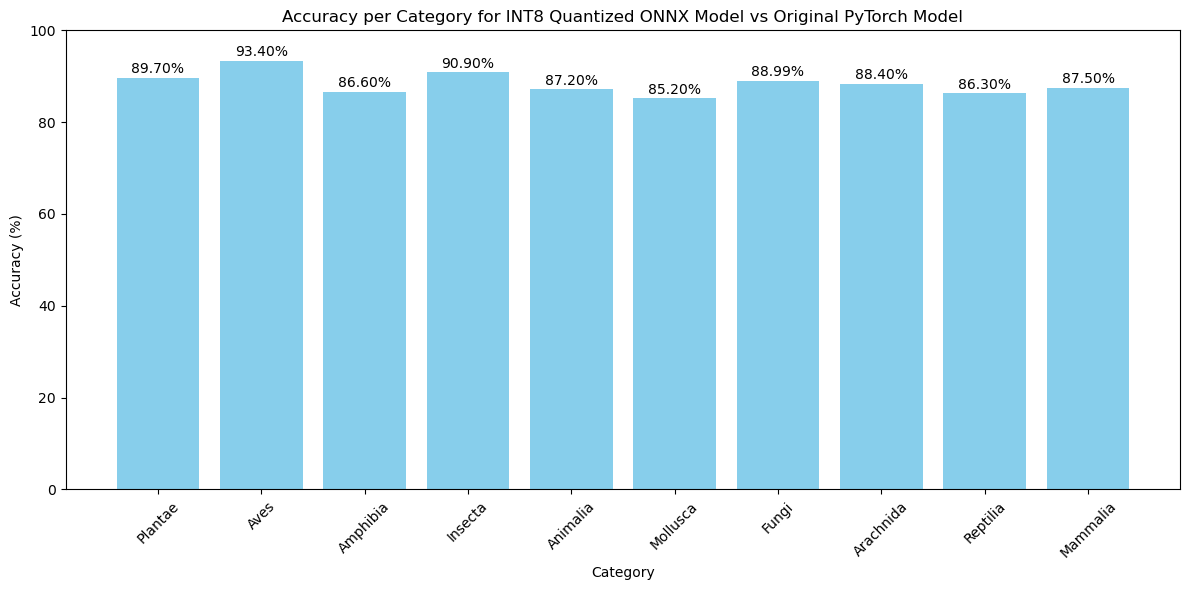

In [21]:
# Display the report results for each category
import matplotlib.pyplot as plt
category_correct = {}

with open("accuracy_report.txt", "r") as report_file:
    report_lines = report_file.readlines()
categories = []
accuracies = []
for line in report_lines[2:]:
    if line.startswith("Category"):
        parts = line.split("'")
        category = parts[1]
        correct_total = parts[2].split("correct images with total of")
        correct = int(correct_total[0].removeprefix(": ").strip())
        total = int(correct_total[1].strip().split()[0])
        accuracy = correct / total * 100
        categories.append(category)
        accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(categories, accuracies, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Category for INT8 Quantized ONNX Model vs Original PyTorch Model')
plt.ylim(0, 100)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.savefig("accuracy_per_category.png")
plt.show()
